# Comparing adaptive and constant step size SDE solvers for the SABR model

In [1]:
from helpers import SDE, simple_sde_order
from warnings import simplefilter

from notebooks.drawing_and_evaluating import remove_steps

simplefilter("ignore", category=FutureWarning)

import numpy as np
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
from diffrax import (
    AbstractBrownianPath,
    diffeqsolve,
    Euler,  # noqa: F401
    MultiTerm,
    ODETerm,
    PIDController,
    SABRController,
    SaveAt,
    SpaceTimeLevyArea,
    SPaRK,
    WeaklyDiagonalControlTerm,
    JumpStepWrapper,
    Heun,  # noqa: F401
    StepTo,
)
from drawing_and_evaluating import (
    constant_step_strong_order,  # noqa: F401
    draw_order_multiple_dict,
    load_order_results,  # noqa: F401
    save_order_results,  # noqa: F401
    get_fine_solutions,  # noqa: F401
    remove_steps,
)
from helpers import simple_batch_sde_solve


jax.config.update("jax_enable_x64", True)


# Define the SABR model
def drift(t, y, args):
    return jnp.array([0.0, -0.5], dtype=y.dtype)


def diffusion(t, y, args):
    v = y[1]
    sigma = jnp.exp(v)
    return jnp.array([sigma, 1.0], dtype=y.dtype)


def get_terms(bm: AbstractBrownianPath):
    return MultiTerm(ODETerm(drift), WeaklyDiagonalControlTerm(diffusion, bm))


# Initial value is (0, 0)
y0 = jnp.array([0.0, 0.0], dtype=jnp.float64)

# Time will run from 0 to 10
t0, t1 = 0.0, 8.0
bm_tol = 2**-13
level_coarse = 5
save_ts = jnp.linspace(t0, t1, 2**level_coarse + 1, endpoint=True)
saveat = SaveAt(ts=save_ts)

sabr_sde = SDE(get_terms, None, y0, t0, t1, (2,))

# We will use 100000 sample paths to estimate the order
num_samples = 100000
key = jr.key(3)
keys = jr.split(key, num_samples)

### Drawing of a single sample path

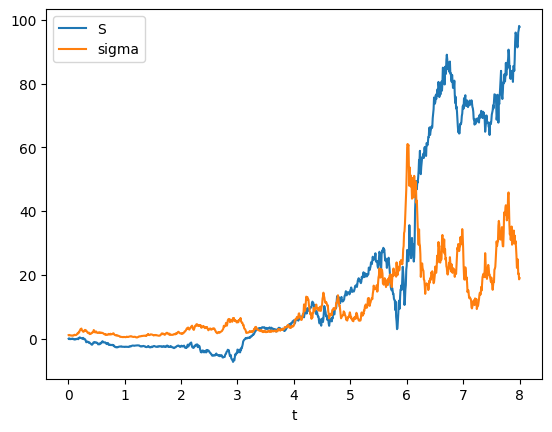

In [2]:
bm_key = jr.key(9)
terms_sabr = get_terms(sabr_sde.get_bm(bm_key, SpaceTimeLevyArea, 2**-8))
sol = diffeqsolve(terms_sabr, SPaRK(), t0, t1, 2**-7, y0, saveat=SaveAt(steps=True))
plt.plot(sol.ts, sol.ys[:, 0], label="S")
plt.plot(sol.ts, jnp.exp(sol.ys[:, 1]), label="sigma")
plt.xlabel("t")
plt.legend()
plt.show()

In [3]:
# Compute reference solution
# ref_controller = StepTo(ts=jnp.linspace(t0, t1, 2**14 + 1, endpoint=True))
# ref_sol, _ = simple_batch_sde_solve(
#     keys, sabr_sde, SPaRK(), SpaceTimeLevyArea, None, ref_controller, bm_tol, saveat
# )
# np.save("sabr_reference_solution.npy", ref_sol)
ref_sol = np.load("sabr_reference_solution.npy")

### Strong order using PI controller

Below we use a PI controller to adapt the step size. We modified the controller so that it revisits all the rejected steps. This guarantees that the numerical solution converges to the true SDE solution. See Theorem 2.19 of Foster and Jelinčič (2024):

@misc{foster2024convergence,
      title={On the convergence of adaptive approximations for stochastic differential equations}, 
      author={James Foster and Andraž Jelinčič},
      year={2024},
      eprint={2311.14201},
      archivePrefix={arXiv},
      primaryClass={math.NA},
      url={https://arxiv.org/abs/2311.14201}, 
}

The parameters $K_P = 0.1$ and $K_I = 0.3$ for the PI controller were chosen based on recommendations from the Diffrax documentation and from Ilie et al. (2015):

@article{ilie2015adaptive,
  author={Ilie, Silvana and Jackson, Kenneth R. and Enright, Wayne H.},
  title={{A}daptive {T}ime-{S}tepping for the {S}trong {N}umerical {S}olution
         of {S}tochastic {D}ifferential {E}quations},
  year={2015},
  publisher={Springer-Verlag},
  address={Berlin, Heidelberg},
  volume={68},
  number={4},
  doi={https://doi.org/10.1007/s11075-014-9872-6},
  journal={Numer. Algorithms},
  pages={791–-812},
}

In [4]:
def pid_strong_order(keys, sde, solver, levels):
    def get_pid(level):
        pid = PIDController(
            pcoeff=0.1,
            icoeff=0.3,
            rtol=0,
            atol=2**-level,
            dtmin=2**-12,
            dtmax=0.25,
            force_dtmin=True,
        )
        controller = JumpStepWrapper(
            pid,
            step_ts=save_ts,
            rejected_step_buffer_len=20
        )
        return None, controller

    return simple_sde_order(
        keys, sde, solver, solver, levels, get_pid, saveat, bm_tol, levy_area=SpaceTimeLevyArea,
        ref_solution=None
    )


# spark_pid = pid_strong_order(keys, sabr_sde, SPaRK(), (1, 7))
# save_order_results(spark_pid, "spark_pid")
spark_pid = load_order_results("spark_pid")
spark_pid = remove_steps(spark_pid, 1, 0)

# heun_pid = pid_strong_order(keys, sabr_sde, Heun(), (3, 9))
# save_order_results(heun_pid, "heun_pid")
heun_pid = load_order_results("heun_pid")

Loaded order_results/order_results_spark_pid.npy
7
Loaded order_results/order_results_heun_pid.npy


### Strong order using constant step size

In [5]:
# spark_const = constant_step_strong_order(keys, sabr_sde, SPaRK(), (6, 11), bm_tol, SpaceTimeLevyArea, ref_sol, save_ts)
# save_order_results(spark_const, "spark_const")
spark_const = load_order_results("spark_const")

# heun_const = constant_step_strong_order(keys, sabr_sde, Heun(), (7, 12), bm_tol, SpaceTimeLevyArea, ref_sol, save_ts)
# save_order_results(heun_const, "heun_const")
heun_const = load_order_results("heun_const")

# euler_const = constant_step_strong_order(keys, sabr_sde, Euler(), (8, 13), bm_tol, SpaceTimeLevyArea, ref_sol, save_ts)
# save_order_results(euler_const, "euler_const")
euler_const = load_order_results("euler_const")

Loaded order_results/order_results_spark_const.npy
Loaded order_results/order_results_heun_const.npy
Loaded order_results/order_results_euler_const.npy


### Strong order using the previsible step size optimized for the SABR model

In [6]:
def sabr_strong_order(keys, sde, solver, levels, previsible=False, euler=False):
    def get_sabr_controller(level: int):
        return None, SABRController(
            ctol=2**-level,
            dtmin=2**-12,
            dtmax=0.25,
            step_ts=save_ts,
            previsible=previsible,
            euler=euler,
        )
    
    return simple_sde_order(
        keys, sde, solver, solver, levels, get_sabr_controller, saveat, bm_tol, levy_area=SpaceTimeLevyArea,
        ref_solution=None
    )


# spark_sabr = sabr_strong_order(keys, sabr_sde, SPaRK(), (-4, 3))
# save_order_results(spark_sabr, "spark_sabr")
# spark_sabr = load_order_results("spark_sabr")
# 
# heun_sabr = sabr_strong_order(keys, sabr_sde, Heun(), (-4, 3))
# save_order_results(heun_sabr, "heun_sabr")
# heun_sabr = load_order_results("heun_sabr")

# spark_previs = sabr_strong_order(keys, sabr_sde, SPaRK(), (-4, 4), previsible=True)
# save_order_results(spark_previs, "spark_previs")
spark_previs = load_order_results("spark_previs")

# heun_previs = sabr_strong_order(keys, sabr_sde, Heun(), (-3, 5), previsible=True)
# save_order_results(heun_previs, "heun_previs")
heun_previs = load_order_results("heun_previs")
heun_previs = remove_steps(heun_previs, 0, 1)

# euler_previs = sabr_strong_order(keys, sabr_sde, Euler(), (-2, 7), previsible=True)
# save_order_results(euler_previs, "euler_previs")
euler_previs = load_order_results("euler_previs")
euler_previs = remove_steps(euler_previs, 0, 1)

Loaded order_results/order_results_spark_previs.npy
Loaded order_results/order_results_heun_previs.npy
9
Loaded order_results/order_results_euler_previs.npy
10


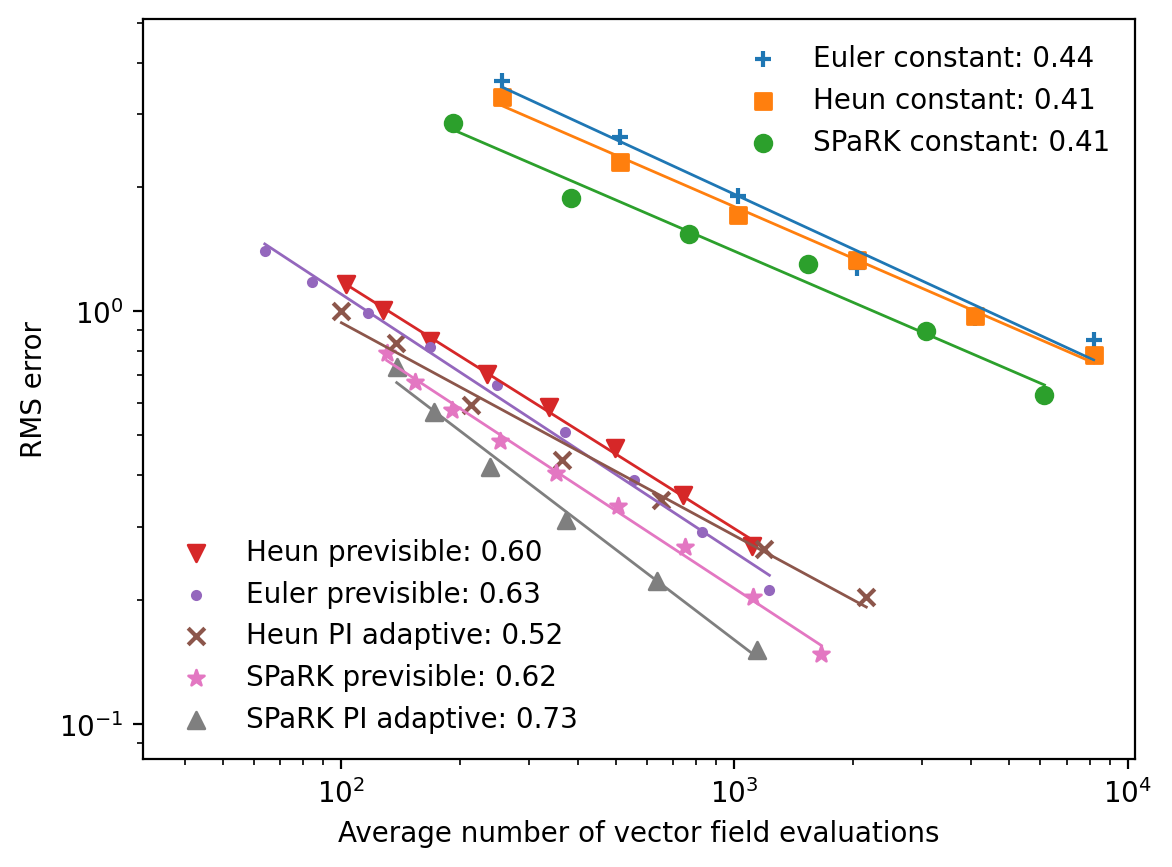

In [7]:
results2 = {
    "Euler constant": euler_const,
    "Heun constant": heun_const,
    "SPaRK constant": spark_const,
    "Heun previsible": heun_previs,
    "Euler previsible": euler_previs,
    "Heun PI adaptive": heun_pid,
    "SPaRK previsible": spark_previs,
    "SPaRK PI adaptive": spark_pid,
}

fig = draw_order_multiple_dict(results2)

In [8]:
name = "split_legend"
fig.savefig(f"{name}.pdf")
fig.savefig(f"{name}.png")